In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
path = 'drive/MyDrive/Tugas 3 DL/'

Mounted at /content/drive


In [2]:
import os
import sys
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.preprocessing import OneHotEncoder, MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, cohen_kappa_score, classification_report

import tensorflow as tf
from tensorflow.keras.initializers import RandomUniform, RandomNormal
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import Conv2D, MaxPool2D, AvgPool2D, Flatten, LeakyReLU
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger, Callback
from tensorflow.keras import optimizers, regularizers
from tensorflow.keras import backend as K
from tensorflow.keras.utils import get_custom_objects

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

np.random.seed(89)
tf.random.set_seed(89)

In [3]:
df = pd.read_csv(path + 'daily_NVDA_preprocessed.csv')
df['labels'].values

array([2, 2, 2, ..., 2, 2, 2])

In [4]:
def get_sample_weights(y):
    """
    calculate the sample weights based on class weights. Used for models with
    imbalanced data and one hot encoding prediction.

    params:
        y: class labels as integers
    """

    y = y.astype(int)  # compute_class_weight needs int labels
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y)

    print("real class weights are {}".format(class_weights), np.unique(y))
    print("value_counts", np.unique(y, return_counts=True))
    sample_weights = y.copy().astype(float)
    for i in np.unique(y):
        sample_weights[sample_weights == i] = class_weights[i]  # if i == 2 else 0.8 * class_weights[i]
        # sample_weights = np.where(sample_weights == i, class_weights[int(i)], y_)

    return sample_weights

first_col, last_col = 'std_3', 'trix_21'

list_features = list(df.loc[:, first_col:last_col].columns)
print('Total number of features:', len(list_features))

x = df.loc[:, first_col:last_col].values
y = df['labels'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=89,
                                                    shuffle=True, stratify=y)


x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, train_size=0.8, random_state=89,
                                                shuffle=True, stratify=y_train)

train_sample_weigths = get_sample_weights(y_train)
cv_sample_weigths = get_sample_weights(y_cv)
test_sample_weigths = get_sample_weights(y_test)

s_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range=(0, 1))

x_train = mm_scaler.fit_transform(x_train)
x_cv = mm_scaler.transform(x_cv)
x_test = mm_scaler.transform(x_test)

# x_train = s_scaler.fit_transform(x_train)
# x_cv = s_scaler.transform(x_cv)
# x_test = s_scaler.transform(x_test)

print(f'All Shape \t\t: x = {x.shape}, y = {y.shape}')
print(f'Train Shape \t\t: x_train = {x_train.shape}, y_test = {y_train.shape}')
print(f'Validation Shape \t: x_cv = {x_cv.shape}, y_cv = {y_cv.shape}')
print(f'Test Shape \t\t: x_test = {x_test.shape}, y_test = {y_test.shape}')

Total number of features: 361
real class weights are [5.63235294 5.68811881 0.37783624] [0 1 2]
value_counts (array([0, 1, 2]), array([ 204,  202, 3041]))
real class weights are [5.63398693 5.74666667 0.37757337] [0 1 2]
value_counts (array([0, 1, 2]), array([ 51,  50, 761]))
real class weights are [5.64831804 5.70061728 0.37770961] [0 1 2]
value_counts (array([0, 1, 2]), array([ 109,  108, 1630]))
All Shape 		: x = (6156, 361), y = (6156,)
Train Shape 		: x_train = (3447, 361), y_test = (3447,)
Validation Shape 	: x_cv = (862, 361), y_cv = (862,)
Test Shape 		: x_test = (1847, 361), y_test = (1847,)


In [5]:
def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

num_features = len(list_features)
dim = int(np.sqrt(num_features))
x_train = reshape_as_image(x_train, dim, dim)
x_cv = reshape_as_image(x_cv, dim, dim)
x_test = reshape_as_image(x_test, dim, dim)

# adding a 1-dim for channels (3)
# x_train = np.stack((x_train,) * 3, axis=-1)
# x_cv = np.stack((x_cv,) * 3, axis=-1)
# x_test = np.stack((x_test,) * 3, axis=-1)

print(f'Train Shape \t\t: x_train = {x_train.shape}, y_test = {y_train.shape}')
print(f'Validation Shape \t: x_cv = {x_cv.shape}, y_cv = {y_cv.shape}')
print(f'Test Shape \t\t: x_test = {x_test.shape}, y_test = {y_test.shape}')

Train Shape 		: x_train = (3447, 19, 19), y_test = (3447,)
Validation Shape 	: x_cv = (862, 19, 19), y_cv = (862,)
Test Shape 		: x_test = (1847, 19, 19), y_test = (1847,)


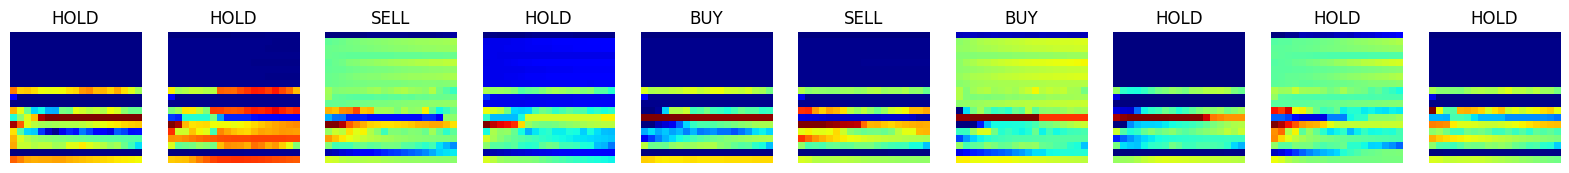

In [6]:
label_dict = {0: 'SELL', 1: 'BUY', 2: 'HOLD'}
def plot_images(images, labels, n, dim):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        img = images[i].reshape(dim, dim)
        img_label = labels[i]
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(img, interpolation='nearest', cmap='jet')
        plt.title(label_dict[int(img_label)])
        plt.axis('off')
    plt.show()

plot_images(x_train[380:], y_train[380:], n=10, dim=dim)

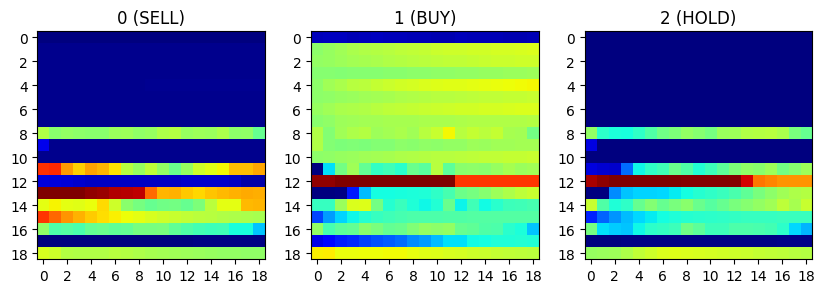

In [7]:
i = 385
# img1, img_label1 = x_train[i:(i+3)].reshape(dim, dim), y_train[i]

fig, ax = plt.subplots(1, 3, figsize=(10,5))
for i in range(3):
    img, img_label = x_train[i+385], y_train[i+385]
    ax[i].imshow(img, cmap='jet', interpolation='nearest')
    ax[i].set_title(f'{int(img_label)} ({label_dict[img_label]})')
    ax[i].set_xticks([2*k for k in range(10)])
    ax[i].set_yticks([2*k for k in range(10)])

plt.savefig('img_example.png')
plt.show()

In [8]:

one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
one_hot_encoder.fit(y_train.reshape(-1, 1))

y_train_oh = one_hot_encoder.transform(y_train.reshape(-1, 1))
y_cv_oh = one_hot_encoder.transform(y_cv.reshape(-1, 1))
y_test_oh = one_hot_encoder.transform(y_test.reshape(-1, 1))

print(f'y_oh Shape: y_train_oh = {y_train_oh.shape}, y_cv_oh = {y_cv_oh.shape}, y_test_oh = {y_test_oh.shape}')

y_oh Shape: y_train_oh = (3447, 3), y_cv_oh = (862, 3), y_test_oh = (1847, 3)


In [ ]:
# x_train = x_train.reshape(x_train.shape[0], 19, 19, 1)
# x_cv = x_cv.reshape(x_cv.shape[0], 19, 19, 1)
# x_train.shape, x_cv.shape

In [ ]:
np.random.seed(89)
tf.random.set_seed(89)

model1 = Sequential()

model1.add(Conv2D(64, kernel_size=(3, 3), strides=(1, 1), padding='same', activation='relu', input_shape=(19, 19, 1)))
model1.add(AvgPool2D(pool_size=(3, 3), strides=(1, 1), padding='valid'))
model1.add(Dropout(rate=0.1))

model1.add(Flatten())

model1.add(Dense(1024, activation='relu'))
model1.add(Dropout(rate=0.3))

model1.add(Dense(3, activation='softmax'))
model1.summary()

model1.compile(optimizer=optimizers.Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,
#                    patience=20, min_delta=0.00001)
# rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
#                               patience=5, min_lr=0.001)

checkpoint_path = (path + 'checkpoint')

rlp = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', verbose=1,
                        min_delta=0.001, min_lr=0.0001)

mcp = ModelCheckpoint(checkpoint_path, monitor='val_loss', verbose=1,
                      save_best_only=True, save_weights_only=False, mode='min', period=1, )

history = model1.fit(x_train, y_train_oh, batch_size=64, shuffle=True, epochs=50,
                     validation_data=(x_cv, y_cv_oh), callbacks=[rlp],
                     sample_weight=train_sample_weigths)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 64)        640       
                                                                 
 average_pooling2d (Average  (None, 17, 17, 64)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 17, 17, 64)        0         
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dense (Dense)               (None, 1024)              18940928  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

Epoch 1/50
54/54 [==============================] - 6s 21ms/step - loss: 0.9652 - accuracy: 0.3644 - val_loss: 0.7478 - val_accuracy: 0.6067 - lr: 0.0010
Epoch 2/50
54/54 [==============================] - 1s 12ms/step - loss: 0.6709 - accuracy: 0.4555 - val_loss: 0.8286 - val_accuracy: 0.5360 - lr: 0.0010
Epoch 3/50
54/54 [==============================] - 1s 12ms/step - loss: 0.6204 - accuracy: 0.4749 - val_loss: 0.6721 - val_accuracy: 0.6311 - lr: 0.0010
Epoch 4/50
54/54 [==============================] - 1s 13ms/step - loss: 0.5985 - accuracy: 0.5045 - val_loss: 1.1915 - val_accuracy: 0.4316 - lr: 0.0010
Epoch 5/50
54/54 [==============================] - 1s 13ms/step - loss: 0.5616 - accuracy: 0.5210 - val_loss: 0.9613 - val_accuracy: 0.5012 - lr: 0.0010
Epoch 6/50
54/54 [==============================] - 1s 12ms/step - loss: 0.5540 - accuracy: 0.5129 - val_loss: 0.9748 - val_accuracy: 0.4780 - lr: 0.0010
Epoch 7/50
54/54 [==============================] - 1s 10ms/step - loss: 0.5

In [ ]:
labels = ['Sell', 'Buy', 'Hold']
y_pred_oh = model1.predict(x_train)
y_pred = [y.argmax() for y in y_pred_oh]
print(classification_report(y_train, y_pred, zero_division=0))
confusion_matrix(y_train, y_pred)

108/108 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.19      0.97      0.32       204
           1       0.22      0.97      0.36       202
           2       0.99      0.50      0.66      3041

    accuracy                           0.55      3447
   macro avg       0.47      0.81      0.45      3447
weighted avg       0.90      0.55      0.62      3447



array([[ 198,    0,    6],
       [   0,  195,    7],
       [ 830,  700, 1511]])

In [ ]:
y_pred_oh = model1.predict(x_cv)
y_pred = [y.argmax() for y in y_pred_oh]
print(classification_report(y_cv, y_pred, zero_division=0))
confusion_matrix(y_cv, y_pred)

27/27 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.19      0.92      0.31        51
           1       0.23      0.96      0.37        50
           2       0.99      0.53      0.69       761

    accuracy                           0.57       862
   macro avg       0.47      0.80      0.46       862
weighted avg       0.89      0.57      0.65       862



array([[ 47,   0,   4],
       [  0,  48,   2],
       [201, 160, 400]])

In [ ]:
y_pred_oh = model1.predict(x_test)
y_pred = [y.argmax() for y in y_pred_oh]
print(classification_report(y_test, y_pred, zero_division=0))
confusion_matrix(y_test, y_pred)

58/58 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.18      0.87      0.30       109
           1       0.20      0.93      0.33       108
           2       0.97      0.50      0.66      1630

    accuracy                           0.54      1847
   macro avg       0.45      0.76      0.43      1847
weighted avg       0.88      0.54      0.62      1847



array([[ 95,   0,  14],
       [  0, 100,   8],
       [424, 397, 809]])

In [ ]:
model1.save(path + 'my_model1.h5', save_format='h5')
model1.save(path + 'my_model1.keras', save_format='keras')

In [10]:
model1 = tf.keras.models.load_model(path + 'my_model1.keras')
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 19, 19, 64)        640       
                                                                 
 average_pooling2d (Average  (None, 17, 17, 64)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 17, 17, 64)        0         
                                                                 
 flatten (Flatten)           (None, 18496)             0         
                                                                 
 dense (Dense)               (None, 1024)              18940928  
                                                                 
 dropout_1 (Dropout)         (None, 1024)              0         
                                                        

In [11]:
model1.evaluate(x_test, y_test_oh)

58/58 [==============================] - 7s 103ms/step - loss: 0.7632 - accuracy: 0.5436


[0.7632278203964233, 0.5435841679573059]

In [ ]:
y_pred_oh = model1.predict(x_test)
y_pred = [y.argmax() for y in y_pred_oh]
print(classification_report(y_test, y_pred, zero_division=0))
confusion_matrix(y_test, y_pred)

58/58 [==============================] - 0s 4ms/step
              precision    recall  f1-score   support

           0       0.18      0.87      0.30       109
           1       0.20      0.93      0.33       108
           2       0.97      0.50      0.66      1630

    accuracy                           0.54      1847
   macro avg       0.45      0.76      0.43      1847
weighted avg       0.88      0.54      0.62      1847



array([[ 95,   0,  14],
       [  0, 100,   8],
       [424, 397, 809]])

In [ ]:
first_col, last_col = 'std_3', 'trix_21'

list_features = list(df_pred.loc[:, first_col:last_col].columns)
print('Total number of features:', len(list_features))

x = df_pred.loc[:, first_col:last_col].values
y = df_pred['labels'].values

sample_weigths = get_sample_weights(y)

s_scaler = StandardScaler()
mm_scaler = MinMaxScaler(feature_range=(0, 1))

x = mm_scaler.fit_transform(x)

# x_train = s_scaler.fit_transform(x_train)
# x_cv = s_scaler.transform(x_cv)
# x_test = s_scaler.transform(x_test)

print(f'All Shape \t\t: x = {x.shape}, y = {y.shape}')

def reshape_as_image(x, img_width, img_height):
    x_temp = np.zeros((len(x), img_height, img_width))
    for i in range(x.shape[0]):
        x_temp[i] = np.reshape(x[i], (img_height, img_width))

    return x_temp

num_features = len(list_features)
dim = int(np.sqrt(num_features))
x = reshape_as_image(x, dim, dim)

# adding a 1-dim for channels (3)
# x = np.stack((x,) * 3, axis=-1)

print(f'Shape: x = {x.shape}, y = {y.shape}')

one_hot_encoder = OneHotEncoder(sparse_output=False, categories='auto')
one_hot_encoder.fit(y.reshape(-1, 1))

y_oh = one_hot_encoder.transform(y.reshape(-1, 1))

print(f'y_oh: y_oh = {y_oh.shape}')

Total number of features: 361
real class weights are [5.63736264 5.7        0.37776141] [0 1 2]
value_counts (array([0, 1, 2]), array([ 364,  360, 5432]))
All Shape 		: x = (6156, 361), y = (6156,)
Shape: x = (6156, 19, 19), y = (6156,)
y_oh: y_oh = (6156, 3)


In [ ]:
y_pred_oh = model1.predict(x)
y_pred = [y.argmax() for y in y_pred_oh]
print(classification_report(y, y_pred, zero_division=0))
confusion_matrix(y, y_pred)

193/193 [==============================] - 1s 3ms/step
              precision    recall  f1-score   support

           0       0.18      0.96      0.30       364
           1       0.22      0.95      0.35       360
           2       0.99      0.47      0.64      5432

    accuracy                           0.53      6156
   macro avg       0.46      0.79      0.43      6156
weighted avg       0.89      0.53      0.60      6156



array([[ 348,    0,   16],
       [   0,  343,   17],
       [1607, 1251, 2574]])

In [ ]:
df_pred = df.copy()
df_pred['predictions'] = np.array(y_pred)
df_pred.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6156 entries, 0 to 6155
Columns: 370 entries, index to predictions
dtypes: float64(365), int64(4), object(1)
memory usage: 17.4+ MB


In [ ]:
BUY1 = [None for i in range(len(df_pred))]
SELL1 = [None for i in range(len(df_pred))]
HOLD1 = [None for i in range(len(df_pred))]
buy1 = 0
sell1 = 0
hold1 = 0

for i in range(len(df_pred['predictions'])):
  if df_pred['predictions'][i] == 1 :
    BUY1[i] = (df_pred['close'][i])
    buy1 += 1
  if df_pred['predictions'][i] == 0 :
    SELL1[i] = (df_pred['close'][i])
    sell1 += 1
  if df_pred['predictions'][i] == 2 :
    HOLD1[i] = (df_pred['close'][i])
    hold1 += 1

print("Jumlah Prediksi Label Saham SELL (0) adalah : ", sell1)
print("Jumlah Prediksi Label Saham BUY (1) adalah : ", buy1)
print("Jumlah Prediksi Label Saham HOLD (2) adalah : ", hold1)

Jumlah Prediksi Label Saham SELL (0) adalah :  1955
Jumlah Prediksi Label Saham BUY (1) adalah :  1594
Jumlah Prediksi Label Saham HOLD (2) adalah :  2607


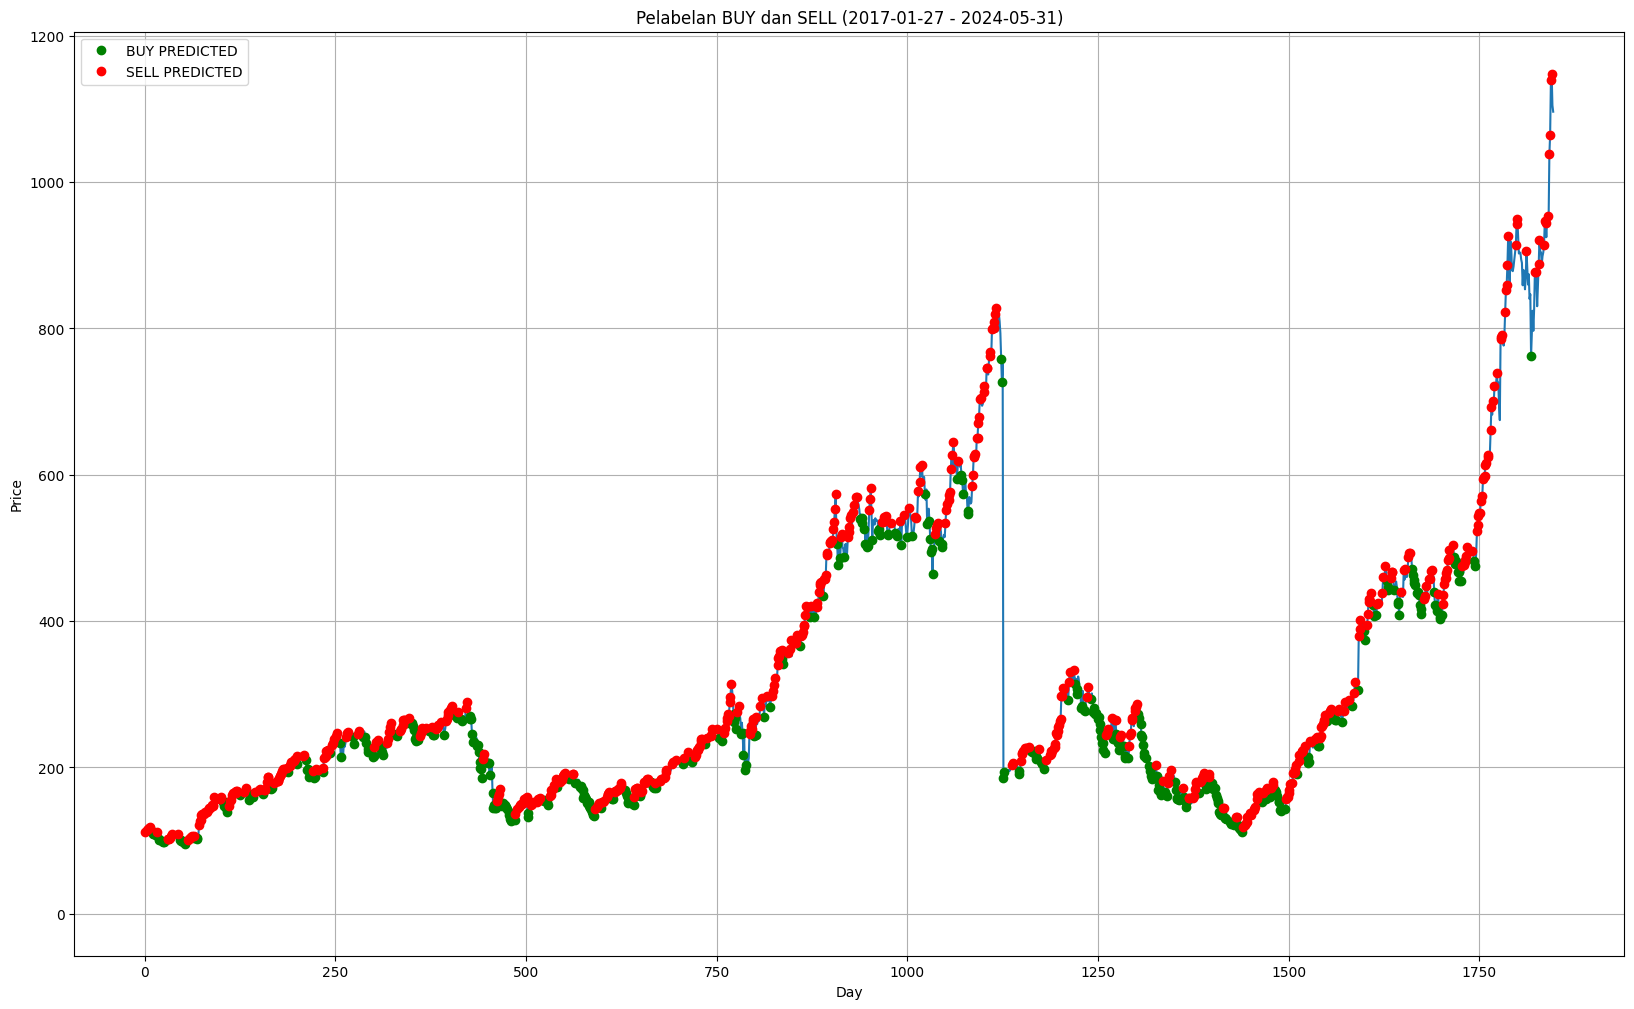

In [ ]:
fig, ax = plt.subplots(figsize=(20, 12))
# ax.set_facecolor('black')
start, end = len(df_pred) - 1848, len(df_pred)
margin = 0.05 * (end-start)

plt.plot(np.array(df_pred['close'][start:end]))
plt.plot(BUY1[start:end], 'go', label='BUY PREDICTED')
plt.plot(SELL1[start:end], 'ro', label='SELL PREDICTED')
# plt.plot(HOLD1[start:end], 'bo', label='HOLD PREDICTED')
plt.hlines(0, xmin=start, xmax=end)
plt.title(f'Prediksi pelabelan BUY dan SELL ({df_pred.timestamp[start]} - {df_pred.timestamp[(end-1)]})')
plt.legend()
plt.xlabel("Day")
plt.ylabel("Price")
# plt.xticks(range(start, end, 1000))
plt.xlim([-margin, (end-start) + margin])
# plt.ylim(0,70)
plt.grid()

plt.show()